In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import glob
import math
import random
import time
import datetime
from collections import defaultdict
from tqdm import tqdm, tqdm_notebook

import xml.etree.ElementTree as ET 

import cv2
# plt.style.use('ggplot')

print(os.listdir("../data"))

['Annotation', 'Annotation.zip', 'all-dogs', '.DS_Store', 'all-dogs.zip']


In [55]:
import tensorflow as tf

In [6]:
image_width = 64
image_height = 64
image_channels = 3
# image_sample_size = 10000
# image_output_dir = '../output_images/'
image_input_dir = '../data/all-dogs/'
image_ann_dir = "../data/Annotation/"

In [39]:
dog_breed_dict = {}
for annotation in os.listdir(image_ann_dir):
    try:
        annotations = annotation.split('-')
        dog_breed_dict[annotations[0]] = annotations[1]
    except:
        pass

In [44]:
def get_input_image_dict(image_input_dir, labels_dict):
    image_sample_dict = defaultdict(list)
    for image in os.listdir(image_input_dir):
        filename = image.split('.')
        label_code = filename[0].split('_')[0]
        breed_name = labels_dict[label_code]
        #print('Code: {}, Breed: {}'.format(label_code, breed_name))
        if image is not None:
            image_sample_dict[breed_name].append(image)
    
    print('Created label dictionary for input images.')
    return image_sample_dict

In [45]:
image_sample_dict = get_input_image_dict(image_input_dir, dog_breed_dict)

Created label dictionary for input images.


In [46]:
def plot_class_distributions(image_sample_dict, title=''):
    class_lengths = []
    labels = []
    total_images = 0
    
    print('Total amount of dog breeds: ', len(image_sample_dict))
    
    for label, _ in image_sample_dict.items():
        total_images += len(image_sample_dict[label])
        class_lengths.append(len(image_sample_dict[label]))
        labels.append(label)
        
    print('Total amount of input images: ', total_images)
        
    plt.figure(figsize = (10,30))
    plt.barh(range(len(class_lengths)), class_lengths)
    plt.yticks(range(len(labels)), labels)
    plt.title(title)
    plt.ylabel('Dog Breed')
    plt.xlabel('Sample size')
    plt.show()
    
    return total_images

('Total amount of dog breeds: ', 120)
('Total amount of input images: ', 20579)


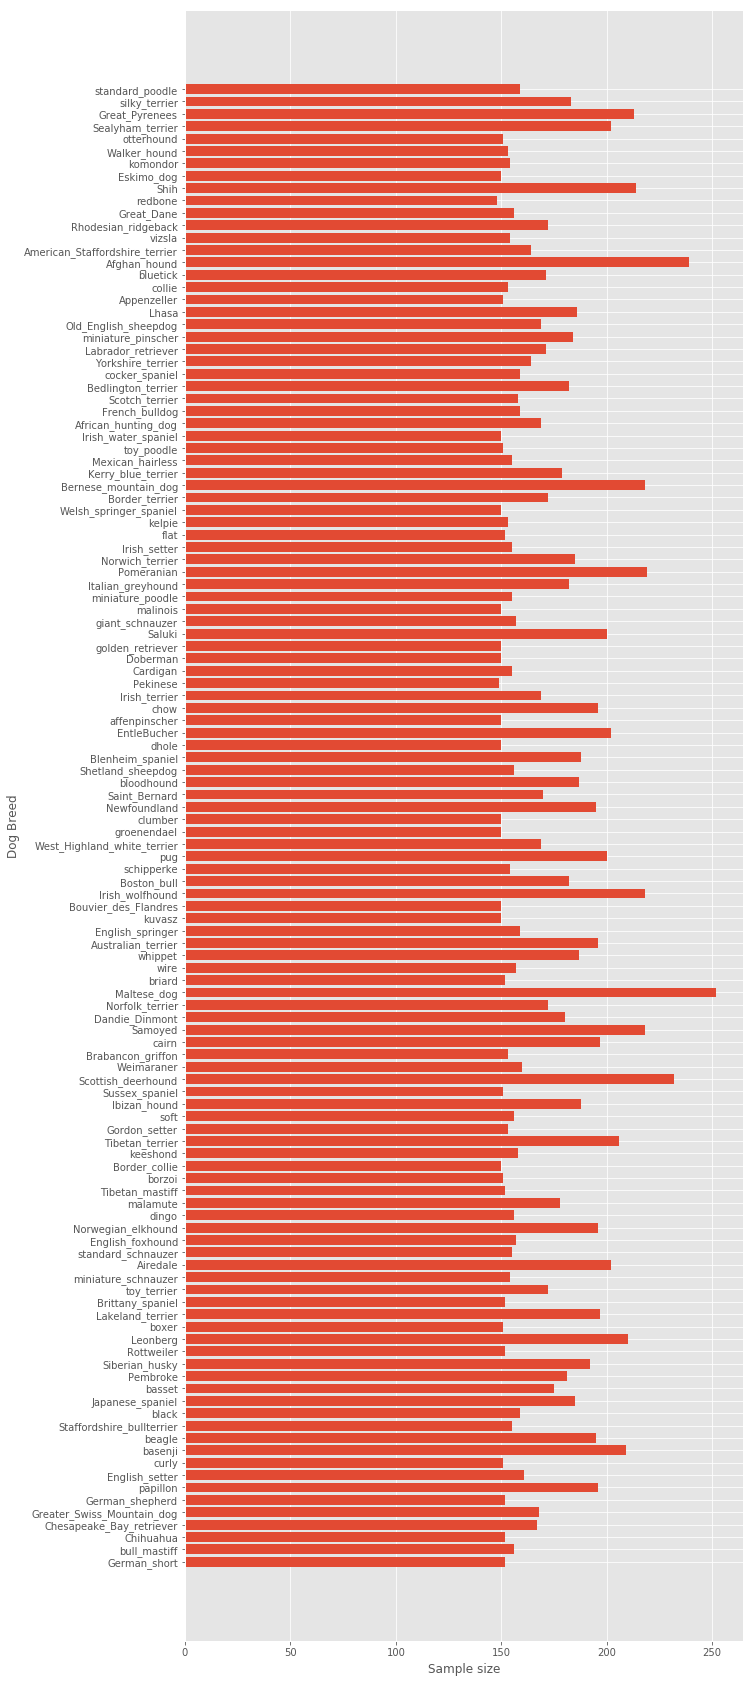

In [49]:
total_images = plot_class_distributions(image_sample_dict)

In [75]:
# To generate GIFs
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs
    
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

# from IPython import display

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [76]:
import tensorflow as tf
from tensorflow.keras import layers
import time

In [79]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [80]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

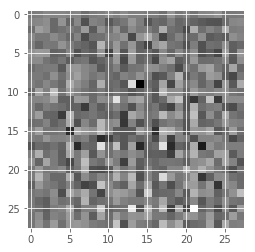

In [86]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [83]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [87]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00227168]], shape=(1, 1), dtype=float32)


In [88]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [89]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [90]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [91]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [97]:
male   = imread(image_input_dir +'n02085620_199.jpg')

(<matplotlib.image.AxesImage at 0x7f49e83a2e50>, (430, 300, 3))

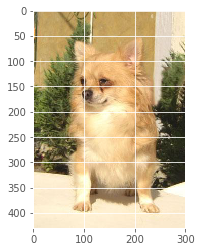

In [100]:
plt.imshow(male), male.shape

In [132]:
def dog_visualizer(filename):
    from skimage.io import imread
    from skimage.transform import rescale, resize, downscale_local_mean

    random_dog=imread(image_input_dir+filename)
    dog_resized = resize(random_dog, (128, 128),
                       anti_aliasing=True)
    
    return plt.imshow(dog_resized), dog_resized.shape,random_dog.shape #, plt.imshow(random_dog)
    

(<matplotlib.image.AxesImage at 0x7f49c43db090>, (128, 128, 3), (430, 300, 3))

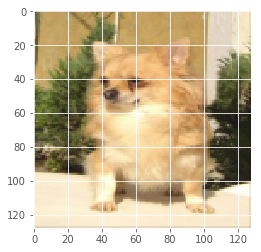

In [133]:
dog_visualizer('n02085620_199.jpg')

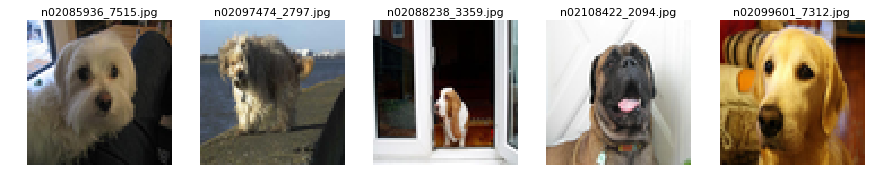

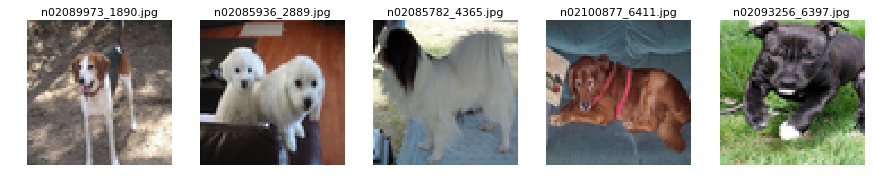

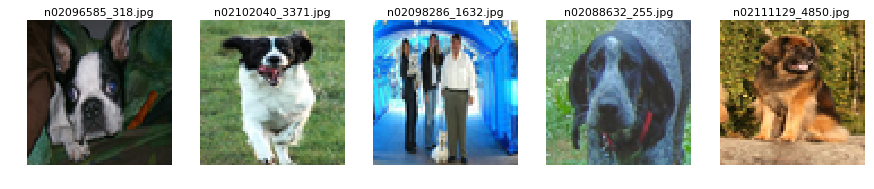

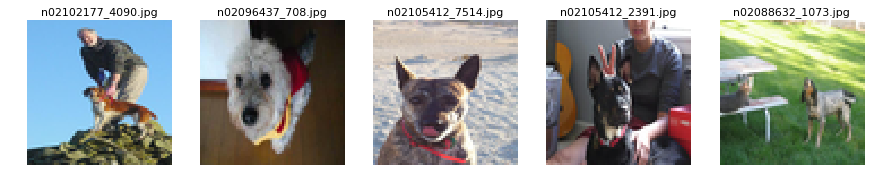

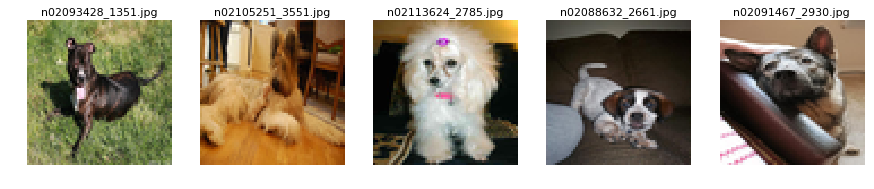

In [143]:
ComputeLB = False
DogsOnly = False

import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

ROOT = '../input/generative-dog-images/'
if not ComputeLB: ROOT = '../data/'
IMAGES = os.listdir(ROOT + 'all-dogs/')
breeds = os.listdir(ROOT + 'Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT+'Annotation/'+breed):
            try: img = Image.open(ROOT+'all-dogs/all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse(ROOT+'annotation/Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                #if idxIn%1000==0: print(idxIn)
                namesIn.append(breed)
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    
# RANDOMLY CROP FULL IMAGES
else:
    IMAGES = np.sort(IMAGES)
    np.random.seed(810)
    x = np.random.choice(np.arange(20579),10000)
    np.random.seed(None)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/' + IMAGES[x[k]])
        w = img.size[0]; h = img.size[1];
#         if (k%2==0)|(k%3==0):
#             w2 = 100; h2 = int(h/(w/100))
#             a = 18; b = 0          
#         else:
#             a=0; b=0
#             if w<h:
#                 w2 = 64; h2 = int((64/w)*h)
#                 b = (h2-64)//2
#             else:
#                 h2 = 64; w2 = int((64/h)*w)
#                 a = (w2-64)//2
        img = img.resize((64,64), Image.ANTIALIAS)
#         img = img.crop((0+a, 0+b, 64+a, 64+b))    
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        #if idxIn%1000==0: print(idxIn)
        idxIn += 1
    
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

In [144]:
IMG_SIZE = Input((12288,))
IMG_SIZE_2 = Input((10000,))
NOISE_SIZE = 10000
#BATCH_SIZE = 256 # orig gives ~7.24
#BATCH_SIZE = 512 # gives ~7.25
#BATCH_SIZE = 128 # gives 7.22594
#BATCH_SIZE = 128 # gives ~7.222
BATCH_SIZE = 64

NameError: name 'Input' is not defined

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 32768)             3276800   
_________________________________________________________________
batch_normalization_69 (Batc (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu_75 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_20 (Reshape)         (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_53 (Conv2DT (None, 16, 16, 256)       3276800   
_________________________________________________________________
batch_normalization_70 (Batc (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_76 (LeakyReLU)   (None, 16, 16, 256)     

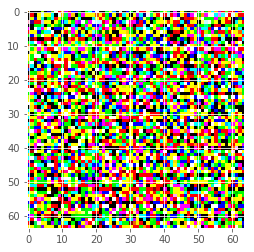

In [177]:
# Weight initializers for the Generator network
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)
import pydot
import graphviz

def g_model():
    model = tf.keras.Sequential(
        [
            # first layer with 32,768 nodes expecting an input of vector size 100 (random noise)
            tf.keras.layers.Dense(8*8*512, use_bias=False, input_shape=(100,)),
            # Normalize the activations of the previous layer at each batch
            tf.keras.layers.BatchNormalization(),
            # apply leaky relu activation: f(x) = {x if x > 0 : 0.01*x}
            tf.keras.layers.LeakyReLU(),
            # reshape input to (8,8,512)
            tf.keras.layers.Reshape((8, 8, 512)),
            
            # second layer Conv2DTranspose so it is doing the opposite of a convolutional layer
            tf.keras.layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', use_bias=False,\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False,\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False,\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Dense(3,activation='tanh', use_bias=False,\
                kernel_initializer=WEIGHT_INIT)
        ]
    )
    return model
# create an instance of the generator model defined
generator = make_generator()
print(generator.summary())

# random noise vector
noise = tf.random.normal([1,100])
# run the generator model with the noise vector as input
generated_image = generator(noise, training=False)
# display output
plt.imshow(generated_image[0, :, :, :])
print(generated_image.shape)

In [179]:
dim = 64
def d_model():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', input_shape=[dim,dim,3],\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
#             tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same',\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
#             tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same',\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
#             tf.keras.layers.Dropout(0.25),
            
            # flatten input into 1-D and output a single a number from the last layer using sigmoid activation
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ]
    )
    return model

discriminator = d_model()
print(discriminator.summary())
decision = discriminator(generated_image)
print (decision)


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 64)        3136      
_________________________________________________________________
batch_normalization_73 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_79 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 128)       131200    
_________________________________________________________________
batch_normalization_74 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_80 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 256)       

In [175]:
from g_model import *

In [176]:
generator = g_model()
print(generator.summary())

# random noise vector
noise = tf.random.normal([1,100])
# run the generator model with the noise vector as input
generated_image = generator(noise, training=False)
# display output
plt.imshow(generated_image[0, :, :, :])
print(generated_image.shape)

NameError: name 'g_model' is not defined

In [168]:
g_model

NameError: name 'g_model' is not defined

In [180]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [181]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [182]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [183]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [184]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [185]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [187]:
seed.shape

TensorShape([16, 100])